In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
# on est obligé de le faire car notre dataset a pas les noms des colonnes
movie_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", # Freebase ID:name tuples
    "Movie_countries", # Freebase ID:name tuples
    "Movie_genres"] # Freebase ID:name tuples

char_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_release_date",
    "Character_name",
    "Actor_date_of_birth",
    "Actor_gender",
    "Actor_height_m", # in meters
    "Actor_ethnicity", # Freebase ID
    "Actor_name",
    "Actor_age_at_movie_release",
    "Freebase_character_actor_map_ID",
    "Freebase_character_ID",
    "Freebase_actor_ID"]

In [78]:
df_movie = pd.read_csv('MovieSummaries/movie.metadata.tsv', delimiter = '\t', names = movie_col_name, header = None)
df_char = pd.read_csv('MovieSummaries/character.metadata.tsv', delimiter = '\t', names = char_col_name, header = None)


In [79]:
print("shape movie:", df_movie.shape)
print("shape char:", df_char.shape)

shape movie: (81741, 9)
shape char: (450669, 13)


In [80]:
print(df_movie.isnull().sum())
print('')
print(df_char.isnull().sum())

Wikipedia_movie_ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64

Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_release_date                   9995
Character_name                     257875
Actor_date_of_birth                106145
Actor_gender                        45609
Actor_height_m                     295845
Actor_ethnicity                    344611
Actor_name                           1228
Actor_age_at_movie_release         158113
Freebase_character_actor_map_ID         0
Freebase_character_ID              257865
Freebase_actor_ID                     815
dtype: int64


In [81]:
#Actor_date_of_bith : type string, 1935-08-13 AAAA-MM-DD
#Movie_release_date : type string, 2001-08-24 AAAA-MM-DD

In [82]:
common_col = set(movie_col_name) & set(char_col_name) # trois colonnes identiques
print(len(common_col))

3


In [83]:
merged_df = pd.merge(df_movie, df_char, on=['Wikipedia_movie_ID', 'Freebase_movie_ID'], how='inner', suffixes=('', '_y'))
merged_df.shape

(450669, 20)

In [84]:
merged_df['Movie_release_date'] = merged_df['Movie_release_date'].combine_first(merged_df['Movie_release_date_y'])

In [85]:
merged_df.drop('Movie_release_date_y', axis =1, inplace = True, errors='ignore')

print(merged_df.shape)
print(merged_df.columns)
print(merged_df.dtypes)


(450669, 19)
Index(['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name',
       'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime',
       'Movie_languages', 'Movie_countries', 'Movie_genres', 'Character_name',
       'Actor_date_of_birth', 'Actor_gender', 'Actor_height_m',
       'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release',
       'Freebase_character_actor_map_ID', 'Freebase_character_ID',
       'Freebase_actor_ID'],
      dtype='object')
Wikipedia_movie_ID                   int64
Freebase_movie_ID                   object
Movie_name                          object
Movie_release_date                  object
Movie_box_office_revenue           float64
Movie_runtime                      float64
Movie_languages                     object
Movie_countries                     object
Movie_genres                        object
Character_name                      object
Actor_date_of_birth                 object
Actor_gender                        object
Ac

In [90]:
merged_df.loc[merged_df['Actor_gender'].isnull(),'Actor_gender'] = 'Unknown'
# on remplace les données de genre par F/M et Unknown quand inconnu. 
#df.loc[mask, colonne] permet de modifier la colonne directement

In [91]:
age_mask = (merged_df['Actor_age_at_movie_release'].isnull()) & (merged_df['Movie_release_date'].notnull()) & (merged_df['Actor_date_of_birth'].notnull())
count_age_incomplete  = merged_df[age_mask].shape[0]
print(count_age_incomplete)
#il y'a 42'858 cas ou l'age est pas donné, mais calculable

0


In [92]:
merged_df['Movie_release_date'] = pd.to_datetime(merged_df['Movie_release_date'], errors='coerce')
merged_df['Actor_date_of_birth'] = pd.to_datetime(merged_df['Actor_date_of_birth'], errors='coerce')

merged_df.loc[age_mask,'Actor_age_at_movie_release'] = (merged_df['Movie_release_date'] - merged_df['Actor_date_of_birth']).dt.days // 365
# on ajoute l'âge de l'acteur au moment de la sortie comme étant la différence entre sa date de naissance et la date de sortie du film

Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_name                              0
Movie_release_date                 176797
Movie_box_office_revenue           349641
Movie_runtime                       50470
Movie_languages                         0
Movie_countries                         0
Movie_genres                            0
Character_name                     257875
Actor_date_of_birth                120782
Actor_gender                            0
Actor_height_m                     295845
Actor_ethnicity                    344611
Actor_name                           1228
Actor_age_at_movie_release         137082
Freebase_character_actor_map_ID         0
Freebase_character_ID              257865
Freebase_actor_ID                     815
dtype: int64


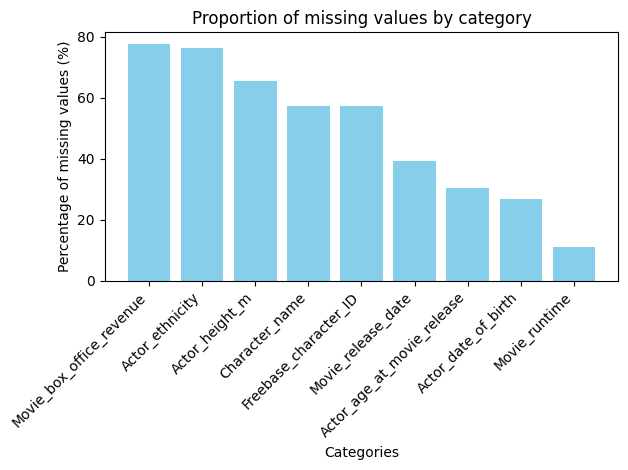

In [93]:
print(merged_df.isnull().sum())
merged_df.head()


proportion_of_null = merged_df.isnull().mean()*100
proportion_of_null = proportion_of_null[proportion_of_null>1] #only missing at least 1% of value
proportion_of_null = proportion_of_null.sort_values(ascending=False)

plt.bar(proportion_of_null.index, proportion_of_null.values, color='skyblue')
plt.title('Proportion of missing values by category')
plt.xlabel('Categories')
plt.ylabel('Percentage of missing values (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyse des valeurs manquantes après traitement des données

## Colonne par colonne

1. **`Movie_release_date`**  
   - Il reste encore beaucoup de valeurs manquantes (176 797), et il semble que ce soit un champ critique pour les analyses historiques.
   - Assure-toi de filtrer les films sans date de sortie pour les analyses chronologiques. Tu peux limiter les analyses de tendance dans le temps aux films avec des dates valides et existantes.
   - DONC créer un dataset avec uniquement les données avec dates de sorties.

2. **`Movie_box_office_revenue`**  
   - Bien que les valeurs manquantes aient été réduites, cette colonne reste très incomplète (349 641 valeurs manquantes).
   - Envisage de limiter l'analyse d'impact commercial (succès au box-office) aux films avec des données valides, ou d'utiliser des imputations de moyenne/médiane par genre ou décennie.
   - DONC créer un dataset avec les données nécessaires et uniquement les valeurs complètes

3. **`Movie_runtime`**  
   - Il y a encore environ 50,470 valeurs manquantes. Pour l’analyse sur la durée des films, tu peux imputer ces valeurs avec la moyenne ou la médiane par genre pour garder un maximum de films dans cette analyse.
   - A PRIORI PAS utile pour nous Potentiellement à enlever
  
4. **`Character_name`** et **`Freebase_character_ID`**  
   - Ces deux colonnes ont encore une proportion importante de valeurs manquantes, mais elles ne sont pas critiques pour les analyses de genre, de succès ou de tendances géographiques.
   - POTENTIELLEMENT à enlever
     
5. **`Actor_date_of_birth`** et **`Actor_age_at_movie_release`**  
   - Ces colonnes sont utiles pour une analyse par âge, mais ont encore une quantité notable de valeurs manquantes (120 782 et 137 082, respectivement).
   - Pour des analyses d'âge, tu peux faire des approximations par groupe d'âge ou bien te concentrer sur les enregistrements complets si l'exactitude est prioritaire.
   - PLUS utile ou peut être pour un bonus. 

6. **`Actor_gender`**  
   - Plus aucune valeur manquante ici !
   - J'ai remplacé les données NaN par Unknown. On peut techniquement faire mieux en supposant que des hommes jouent des hommes et des femmes des femmes, et donc avec le nom du personnage retrouver le genre de l'acteur (Mr. Bean, il est probable qu'il était incarné par un homme)
  

7. **`Actor_ethnicity`** et **`Actor_height_m`**  
   - Étant donné les nombreuses valeurs manquantes, les analyses basées sur ces informations (notamment l'ethnicité) risquent de ne pas être fiables avec ce dataset.
   - Mieux vaut éviter d’inclure ces colonnes dans les analyses, à moins d’accepter une marge d’erreur élevée.
   - A enlever ducoup car inutile pour nous et imcomplet 

In [94]:
#ici on créé le dataset final sur lequel nous allons travailler seulement ceux pour lesquels on a la data de sortie du film
merged_df_dr = merged_df[merged_df.Movie_release_date.notnull()]
print(merged_df_dr.isnull().sum())
#merged_df_dr

Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_name                              0
Movie_release_date                      0
Movie_box_office_revenue           187144
Movie_runtime                       23403
Movie_languages                         0
Movie_countries                         0
Movie_genres                            0
Character_name                     126395
Actor_date_of_birth                 68489
Actor_gender                            0
Actor_height_m                     171764
Actor_ethnicity                    206754
Actor_name                            691
Actor_age_at_movie_release          61379
Freebase_character_actor_map_ID         0
Freebase_character_ID              126385
Freebase_actor_ID                     509
dtype: int64


In [95]:
#ici on créé une nouvelle colonne release year qui contient l
merged_df_dr = merged_df_dr.copy()
merged_df_dr['Movie_release_date'] = merged_df_dr['Movie_release_date'].astype(str)
#print(merged_df_dr['Movie_release_date'].apply(type))
merged_df_dr.loc[:, 'Release_year'] = merged_df_dr['Movie_release_date'].str[:4].astype(int)
#print(merged_df_dr.Movie_release_date.dt.year)
merged_df_dr


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450656,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",UN Spacy Commander,NaT,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1992
450657,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Silvie Gena,NaT,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1992
450658,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Exegran,NaT,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h,1992
450659,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Elensh,NaT,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1992


In [96]:

datafirstplot = merged_df_dr.groupby(["Release_year","Actor_gender"]).Release_year.count()
'''
datafirstplot=datafirstplot.reset_index(name='Count')
datafirstplot.head(20)
'''
datafirstplot = pd.crosstab(merged_df_dr['Release_year'],merged_df_dr['Actor_gender'])
#datafirstplot=datafirstplot.reset_index()
#datafirstplot.index.names=["Index"]
datafirstplot
#plt.plot(datafirstplot.index,datafirstplot.Unknown)

Actor_gender,F,M,Unknown
Release_year,,,
1894,0,1,0
1895,0,1,0
1896,1,1,0
1897,0,1,0
1900,2,2,0
...,...,...,...
2011,4004,7152,384
2012,1959,3554,111
2013,195,478,3


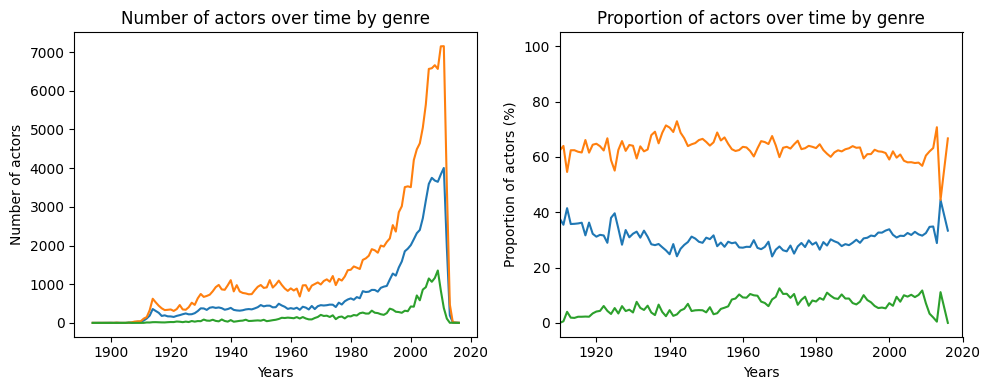

In [97]:
'''
i=0
for index, row in datafirstplot.iterrows():
    plt.plot(datafirstplot.index,datafirstplot.values)
    i=i+1
    print(i)
'''
datafirstplot_proportion = datafirstplot.div(datafirstplot.sum(axis=1), axis=0) * 100

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
for column in datafirstplot.columns:
    ax1.plot(datafirstplot.index, datafirstplot[column], label=column)
    ax2.plot(datafirstplot_proportion.index, datafirstplot_proportion[column], label=column)
    
ax1.set_xlabel("Years")
ax1.set_ylabel("Number of actors")
ax1.set_title("Number of actors over time by genre")
ax2.set_xlabel("Years")
ax2.set_xlim(1910, 2020)
ax2.set_ylabel("Proportion of actors (%)")
ax2.set_title("Proportion of actors over time by genre")

plt.tight_layout()
plt.show()



In [98]:
import pandas as pd
import ast


# Convertit les chaînes en dictionnaires
merged_df_dr['Movie_genres'] = merged_df_dr['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Fonction pour extraire le premier genre
def extract_first_genre(genre_dict):
    if isinstance(genre_dict, dict):
        return next(iter(genre_dict.values()), None)
    return None
def extract_all_genres(genre_dict):
    if isinstance(genre_dict, dict):
        # Récupère toutes les valeurs du dictionnaire
        return list(genre_dict.values())
    return None
# Crée une nouvelle colonne 'principal_genre' avec le premier genre
merged_df_dr['principal_genre'] = merged_df_dr['Movie_genres'].apply(extract_first_genre)




In [99]:
merged_df_dr['Movie_languages'] = merged_df_dr['Movie_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df_dr['language'] = merged_df_dr['Movie_languages'].apply(extract_first_genre)

In [100]:
merged_df_dr.head(20)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,...,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Release_year,principal_genre,language
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Akooshay,...,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,Thriller,English Language
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Lieutenant Melanie Ballard,...,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,Thriller,English Language
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Desolation Williams,...,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,Thriller,English Language
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Sgt Jericho Butler,...,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,Thriller,English Language
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Bashira Kincaid,...,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,Thriller,English Language
5,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Commander Helena Braddock,...,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,2001,Thriller,English Language
6,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Whitlock,...,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,2001,Thriller,English Language
7,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Big Daddy Mars,...,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,2001,Thriller,English Language
8,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Michael Descanso,...,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,2001,Thriller,English Language
9,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},"{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Uno,...,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,2001,Thriller,English Language


In [101]:
#Ici on va créer tout les subdatasets qui nous intéresse
data_boxof = merged_df_dr[merged_df_dr.Movie_box_office_revenue.notnull()]
data_runtime = merged_df_dr[merged_df_dr.Movie_runtime.notnull()]
data_age = merged_df_dr[merged_df_dr.Actor_age_at_movie_release.notnull()]
data_ethn = merged_df_dr[merged_df_dr.Actor_ethnicity.notnull()]
data_height = merged_df_dr[merged_df_dr.Actor_height_m.notnull()]

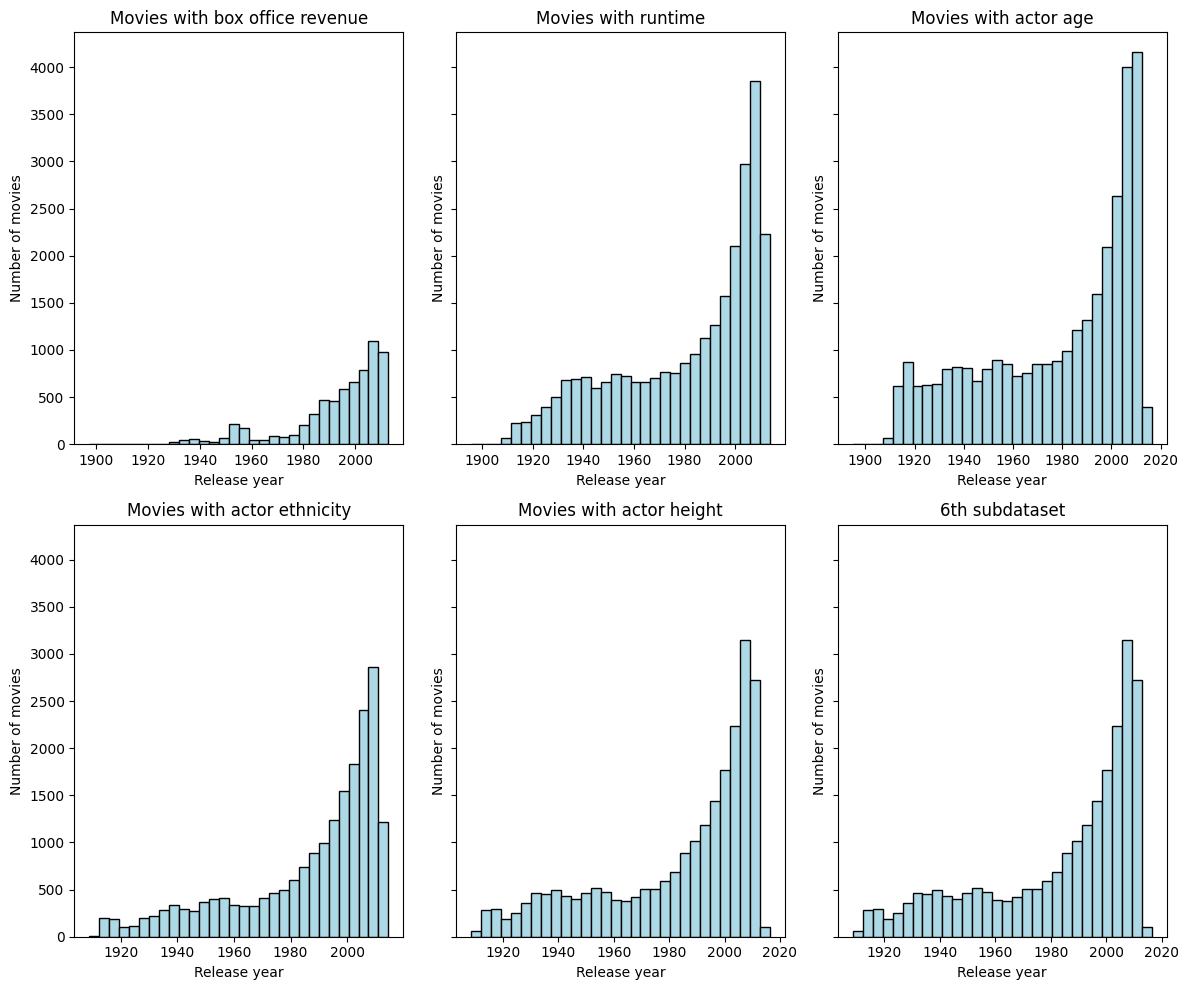

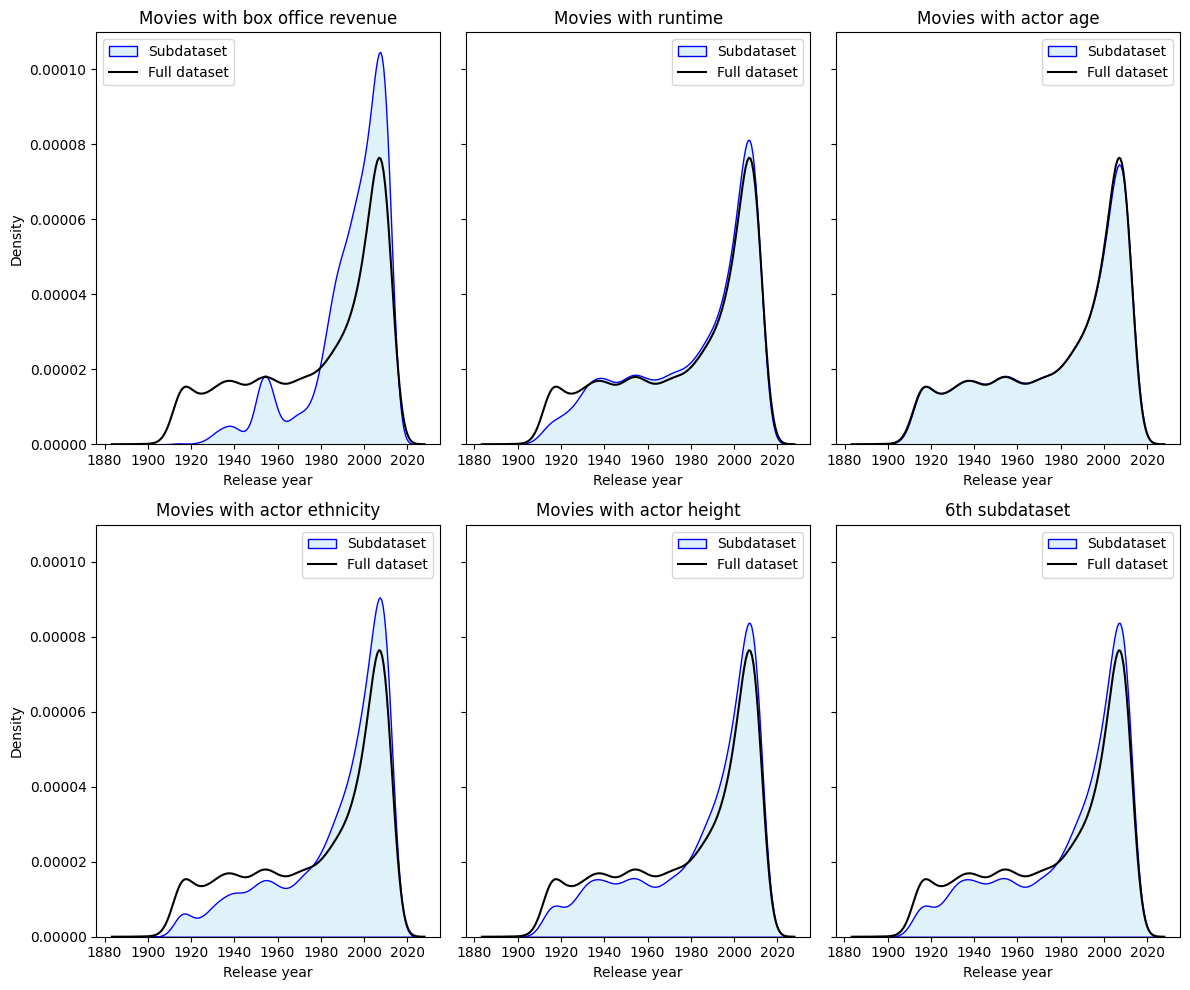

In [ ]:
import seaborn as sns #useful for kernel density estimator

#count the number of unique movie containing the value of the subdataset 
data_age_movies = data_age.drop_duplicates(subset='Movie_name')
data_boxof_movies = data_boxof.drop_duplicates(subset='Movie_name')
data_runtime_movies = data_runtime.drop_duplicates(subset='Movie_name')
data_ethn_movies = data_ethn.drop_duplicates(subset='Movie_name')
data_height_movies = data_height.drop_duplicates(subset='Movie_name')
merged_df_dr_movies = merged_df_dr.drop_duplicates(subset='Movie_name')

subdatasets = [
    (data_boxof_movies, "Movies with box office revenue"),
    (data_runtime_movies, "Movies with runtime"),
    (data_age_movies, "Movies with actor age"),
    (data_ethn_movies, "Movies with actor ethnicity"),
    (data_height_movies, "Movies with actor height"),
    (data_height_movies, "6th subdataset")#if there is a 6th dataset we can plot it here
]


#graph for the different number of movies per subdataset
fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True)
for ax, (data, title) in zip(axes.flatten(), subdatasets):
    ax.hist(data['Movie_release_date'].dropna(), bins=30, color='lightblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel("Release year")
    ax.set_ylabel("Number of movies")
plt.tight_layout()
plt.show()

#for data, title in subdatasets:
#    print(f'{title}: {len(data)}')

#graph for the different density of movies per subdataset
fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True)
for ax, (data, title) in zip(axes.flatten(), subdatasets):
    sns.kdeplot(data['Movie_release_date'].dropna(),ax=ax,fill=True,color='skyblue',edgecolor='blue', label="Subdataset")
    sns.kdeplot(merged_df_dr_movies['Movie_release_date'].dropna(),ax=ax,color='black', label="Full dataset")
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel("Release year")
    ax.set_ylabel("Density")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#still need to fix: does it make sense to plot the number of movies instead of the number of the value itself ?
#does a film which has an age as the age for every actor ? if not is does not make sense to plot the number of movies 
